<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

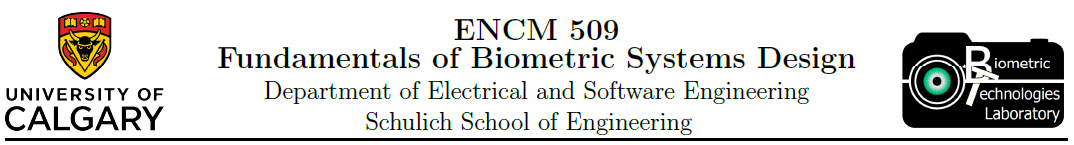

<center>
    <h1>Laboratory Experiment #4</h1>
    <h3>Fingerprint Biometrics - Part I: Preprocessing and Feature Extraction</h3>
</center>

# Lab 4 - Report 

#### UCID 1: 30085789
#### Name 1: Abhay Khosla

#### UCID 2: 30096001
#### Name 2: Parbir Lehal

#### Group Number: 07

## Introduction
In this lab we will exploring image processing via using fingerprint images in .bmp(raw image format) and recognizing the fingerprint using the extracted features. This is a core part of biometric security systems and is used in many applications such as mobile phones, laptops, and other devices. The main goal of this lab is to understand the process of fingerprint recognition and to implement the feature extraction and matching algorithms. We utilized the DigitalPerson USB fingerprint reader to capture the fingerprint images. In this lab exercise we also learn the practical integration of of theoretical knowledge with the essential Python libraries, including the manual installation of OpenCV. This lab serves as a foundational step towards mastering biometric system design, emphasizing critical analysis and feature extraction expertise.

In [2]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils_encm.poincare import calculate_singularities
from utils_encm.segmentation import segmentation
from utils_encm.normalization import normalize
from utils_encm.gabor_filter import gabor_filter
from utils_encm.frequency import ridge_freq
from utils_encm.orientation import calculate_angles, visualize_angles
from utils_encm.crossing_number import calculate_minutiae
from utils_encm.skeletonize import skeletonize
from utils_encm.MatchGaborFeat import MatchGaborFeat
from utils_encm.align2 import align2
from utils_encm.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

C:\Users\abhay\AppData\Local\Temp\ipykernel_18096\1707584806.py:14: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


### Helper Function provided to us in the lab template

In [5]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

**PART I (Lab 4): Specific Questions** 

A detailed description of each exercise to be included in your report (10 marks total) is given below:

**Exercise 1** (3 marks): Select **two fingerprints of different quality (one good and one bad one) from two different fingers each (4 in total)**. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) by adding the **histogram equalization** step. For each fingerprint, perform all the pre-processing, and then add the histogram equalization. Compare the quantity of minutiae and singularities detected WITHOUT and WITH  the histogram equalization step. Record the number of minutiae, the number of singularities for each case. Draw the conclusions from this comparison.

##### Loading and processing-Exercise 1 Good/Bad Left Thumb Fingerprint

In [7]:
# Exercise 1 
# Load Images from the data collected during the lab 
image1GoodLeft = img_as_ubyte(imread('./Abhay Fingerprints/Left Thumb/10.bmp', as_gray=True)) # Converting the image to grayscale
image2BadLeft = img_as_ubyte(imread('./Abhay Fingerprints/Left Thumb/1.bmp', as_gray=True)) # Converting the image to grayscale

# Parameters for processing
seg_threshold = 0.4
block_size = 16

# Image processing
print('Processing good left thumb fingerprint without equalization')
Fp1ProcessingGoodLeft = fingerprint_processing(image1GoodLeft, block_size=block_size, threshold=seg_threshold)
print('Processing bad left thumb fingerprint without equalization')
Fp2ProcessingBadLeft = fingerprint_processing(image2BadLeft, block_size=block_size, threshold=seg_threshold)

# Equalization for contrast enhancement 
image1EqHistGoodLeft = img_as_ubyte(equalize_hist(image1GoodLeft))
image1EqAdaptGoodLeft = img_as_ubyte(equalize_adapthist(image1GoodLeft))

image2EqHistBadLeft = img_as_ubyte(equalize_hist(image2BadLeft))
image2EqAdaptBadLeft = img_as_ubyte(equalize_adapthist(image2BadLeft))

# Image processing after equalization
print('Processing good left thumb fingerprint with equalization adaption')
Fp3ProcessingGoodLeftEqualization = fingerprint_processing(image1EqAdaptGoodLeft, block_size=block_size, threshold=seg_threshold)

print('Processing bad left thumb fingerprint with equalization adaption')
Fp4ProcessingBadLeftEqualization = fingerprint_processing(image2EqAdaptBadLeft, block_size=block_size, threshold=seg_threshold)

Processing good left thumb fingerprint without equalization
Total of minutiae detected: 73
Total of singularities detected: 8
Processing bad left thumb fingerprint without equalization
Total of minutiae detected: 48
Total of singularities detected: 4
Processing good left thumb fingerprint with equalization adaption
Total of minutiae detected: 78
Total of singularities detected: 8
Processing bad left thumb fingerprint with equalization adaption
Total of minutiae detected: 43
Total of singularities detected: 4


##### Plotting the Good Left Thumb Fingerprint with Histogram Equalization and Images

Text(0.5, 0, 'Pixel intensity')

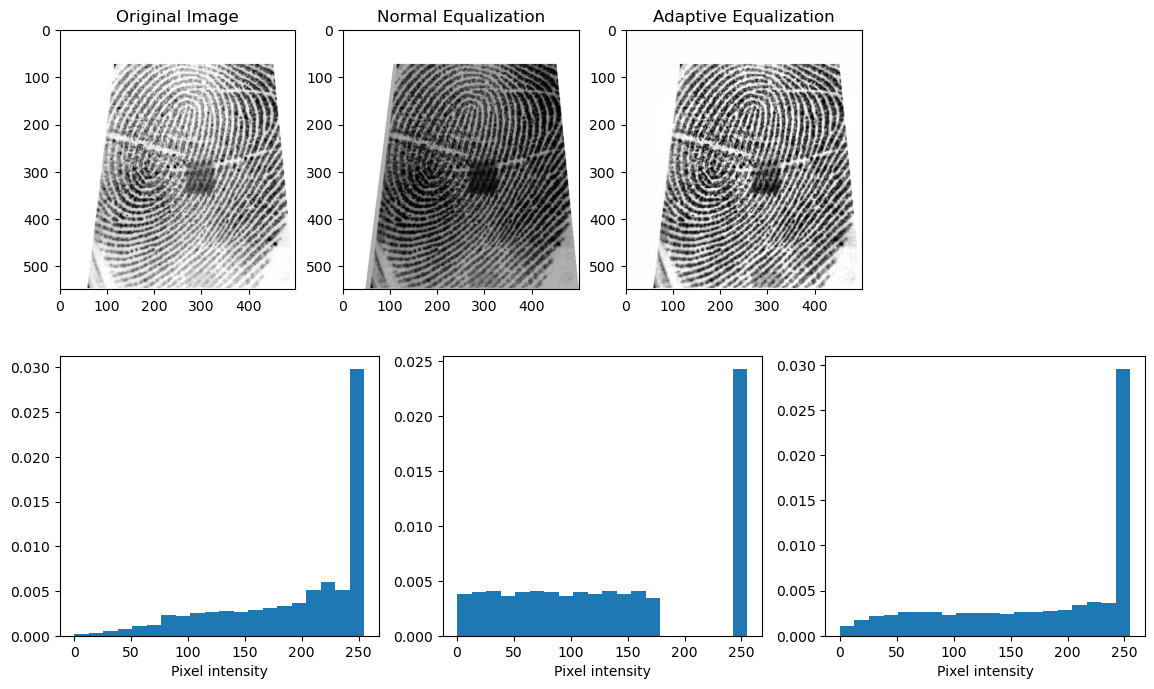

In [8]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1)
plt.imshow(image1GoodLeft, cmap='gray')
plt.title('Original Image')
plt.subplot(2,4,2)
plt.imshow(image1EqHistGoodLeft, cmap='gray')
plt.title('Regular Equalization')
plt.subplot(2,4,3)
plt.imshow(image1EqAdaptGoodLeft, cmap='gray')
plt.title('Adaptive Equalization')
plt.subplot(2,3,4)
plt.hist(image1GoodLeft.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(image1EqHistGoodLeft.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,6)
plt.hist(image1EqAdaptGoodLeft.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')

##### Plotting the Bad Left Thumb Fingerprint with Histogram Equalization and Images

Text(0.5, 0, 'Pixel intensity')

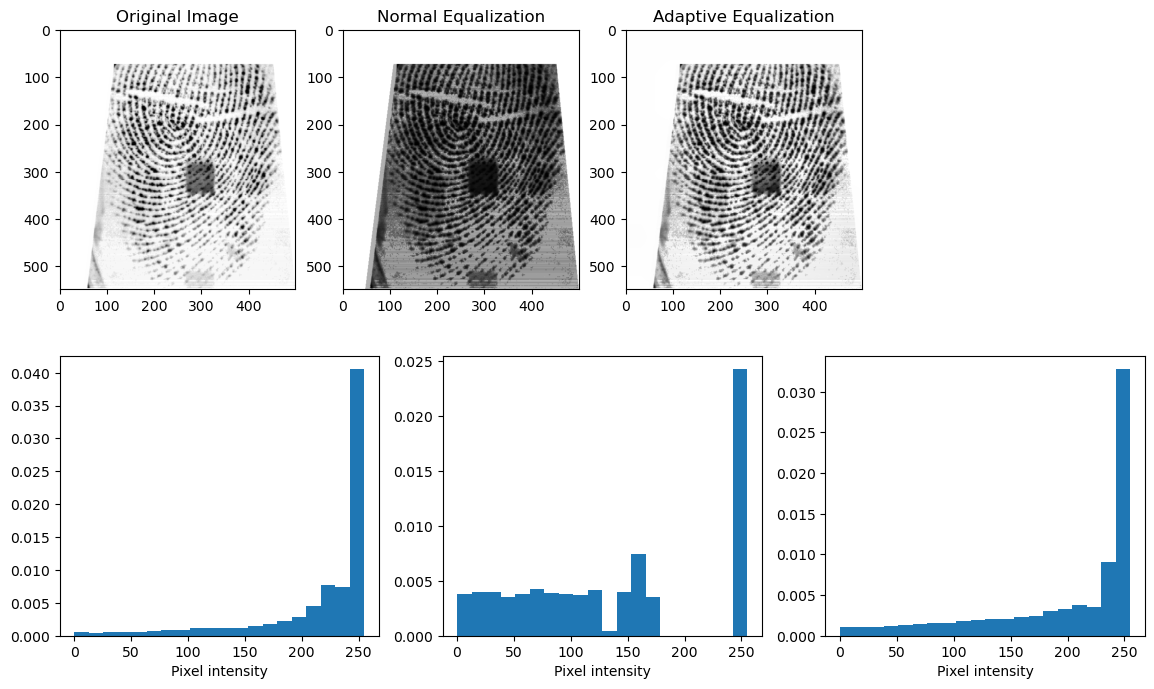

In [9]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1)
plt.imshow(image2BadLeft, cmap='gray')
plt.title('Original Image')
plt.subplot(2,4,2)
plt.imshow(image2EqHistBadLeft, cmap='gray')
plt.title('Regular Equalization')
plt.subplot(2,4,3)
plt.imshow(image2EqAdaptBadLeft, cmap='gray')
plt.title('Adaptive Equalization')
plt.subplot(2,3,4)
plt.hist(image2BadLeft.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(image2EqHistBadLeft.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,6)
plt.hist(image2EqAdaptBadLeft.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')

##### Loading and processing-Exercise 1 Good/Bad Right Thumb Fingerprint

In [26]:
# Exercise 1 
# Load Images from the data collected during the lab 
image1GoodRight = img_as_ubyte(imread('./Abhay Fingerprints/Right Thumb/10.bmp', as_gray=True)) # Converting the image to grayscale
image2BadRight = img_as_ubyte(imread('./Abhay Fingerprints/Right Thumb/3.bmp', as_gray=True)) # Converting the image to grayscale

# Parameters for processing
seg_threshold = 0.4
block_size = 16

# Image processing
print('Processing good right thumb fingerprint without equalization')
Fp1ProcessingGoodRight = fingerprint_processing(image1GoodRight, block_size=block_size, threshold=seg_threshold)
print('Processing bad right thumb fingerprint without equalization')
Fp2ProcessingBadRight = fingerprint_processing(image2BadRight, block_size=block_size, threshold=seg_threshold)

# Equalization for contrast enhancement 
image1EqHistGoodRight = img_as_ubyte(equalize_hist(image1GoodRight))
image1EqAdaptGoodRight = img_as_ubyte(equalize_adapthist(image1GoodRight))

image2EqHistBadRight = img_as_ubyte(equalize_hist(image2BadRight))
image2EqAdaptBadRight = img_as_ubyte(equalize_adapthist(image2BadRight))

# Image processing after equalization
print('Processing good right thumb fingerprint with equalization adaption')
Fp3ProcessingGoodRightEqualization = fingerprint_processing(image1EqAdaptGoodRight, block_size=block_size, threshold=seg_threshold)

print('Processing bad right thumb fingerprint with equalization adaption')
Fp4ProcessingBadRightEqualization = fingerprint_processing(image2EqAdaptBadRight, block_size=block_size, threshold=seg_threshold)

Processing good right thumb fingerprint without equalization
Total of minutiae detected: 82
Total of singularities detected: 4
Processing bad right thumb fingerprint without equalization
Total of minutiae detected: 45
Total of singularities detected: 0
Processing good right thumb fingerprint with equalization adaption
Total of minutiae detected: 87
Total of singularities detected: 4
Processing bad right thumb fingerprint with equalization adaption
Total of minutiae detected: 108
Total of singularities detected: 0


##### Plotting the Good Right Thumb Fingerprint with Histogram Equalization and Images

Text(0.5, 0, 'Pixel intensity')

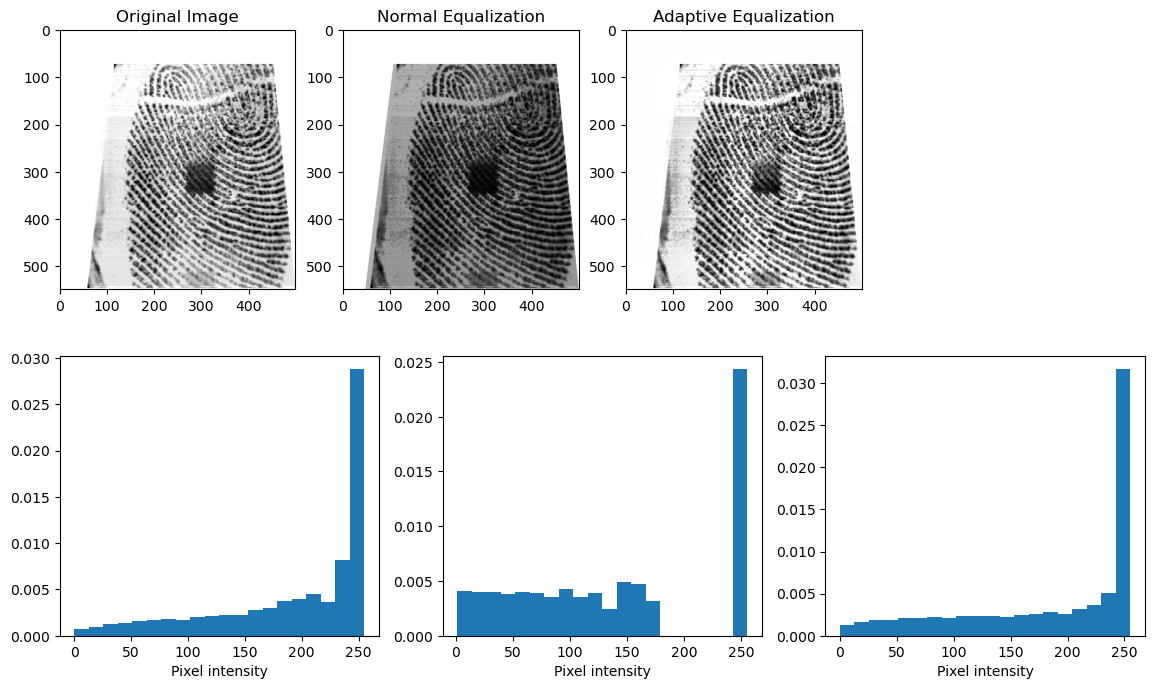

In [17]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1)
plt.imshow(image1GoodRight, cmap='gray')
plt.title('Original Image')
plt.subplot(2,4,2)
plt.imshow(image1EqHistGoodRight, cmap='gray')
plt.title('Regular Equalization')
plt.subplot(2,4,3)
plt.imshow(image1EqAdaptGoodRight, cmap='gray')
plt.title('Adaptive Equalization')
plt.subplot(2,3,4)
plt.hist(image1GoodRight.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(image1EqHistGoodRight.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,6)
plt.hist(image1EqAdaptGoodRight.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')

##### Plotting the Bad Right Thumb Fingerprint with Histogram Equalization and Images

Text(0.5, 0, 'Pixel intensity')

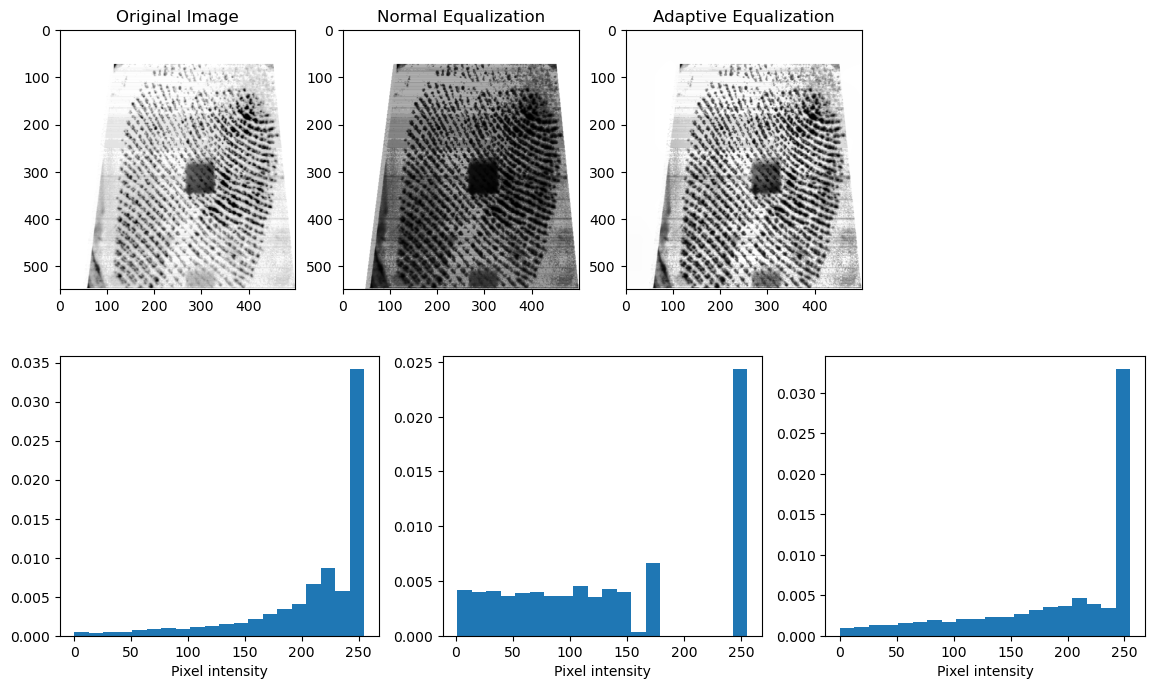

In [18]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1)
plt.imshow(image2BadRight, cmap='gray')
plt.title('Original Image')
plt.subplot(2,4,2)
plt.imshow(image2EqHistBadRight, cmap='gray')
plt.title('Regular Equalization')
plt.subplot(2,4,3)
plt.imshow(image2EqAdaptBadRight, cmap='gray')
plt.title('Adaptive Equalization')
plt.subplot(2,3,4)
plt.hist(image2BadRight.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(image2EqHistBadRight.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,6)
plt.hist(image2EqAdaptBadRight.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')

##### Number of minutiae and singularities detected WITHOUT the histogram equalization step-Left Thumb Fingerprint
| Condition |      Minutiae     |  Singularities |
|----------|:-------------:|------:|
| Good  |  73 | 8 |
| Bad |    48  |   4 |


##### Number of minutiae and singularities detected WITH the histogram equalization step-Left Thumb Fingerprint
| Condition |      Minutiae     |  Singularities |
|----------|:-------------:|------:|
| Good  |  78 | 8 |
| Bad |    43  |   4 |


##### Number of minutiae and singularities detected WITHOUT the histogram equalization step-Right Thumb Fingerprint
| Condition |      Minutiae     |  Singularities |
|----------|:-------------:|------:|
| Good  |  82 | 4 |
| Bad |    45  |   0 |



##### Number of minutiae and singularities detected WITH the histogram equalization step-Right Thumb Fingerprint
| Condition |      Minutiae     |  Singularities |
|----------|:-------------:|------:|
| Good  |  87 | 4 |
| Bad |    108  |   0 |

#### Comparison of the quantity of minutiae and singularities detected WITHOUT and WITH the histogram equalization step
The data that is presented above in the has some variance in the number of minutiae and singularities detected in fingerprints with and without the histogram equalization step. Usually a higher count of minutiae indicates that it increases the uniqueness and the accuracy of identification. For the left thumb fingerprint in good condition, histogram equalization slightly improves minutiae detection but does not affect the singularity detection. For the left thumb fingerprint in bad condition, histogram equalization slightly decreases the minutiae detection which could indicate that over processing could be happening for the singularity detection count is same as also noticed in the left thumb good condition. The right thumb fingerprint in good condition shows a slight increase in minutiae detection and no change in singularity detection. The right thumb fingerprint in bad condition shows a significant increase in minutiae detection and no change in singularity detection. The increase in minutiae detection in the right thumb fingerprint in bad condition could be due to the over processing of the image that there were false minutiae detected or noise in the image that was detected as minutiae. This means that we need more careful parameter choosing for tuning and validation when using histogram equalization to ensure the enhancement process does not introduce artifacts or noise in the image.   

<b>Note: Our findings could result in a different set because the choosing of the fingerprints is based on our judgment and we might consider different aspects. Henceforth these are not generalized instead based on our data which is uploaded with the lab submission.</b>

**Exercise 2** (3 marks): In this Exercise, perform the same steps as in exercise 1, but instead of histogram equalization, choose one **de-noising** method such as *Wiener* or *Median* filter. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) accordingly, record the outcomes and draw the conclusions. 

##### Loading and processing with De-noising-Exercise 2 Good/Bad Left Thumb Fingerprint

In [7]:
# Exercise 2 
# Load Images from the data collected during the lab 
image1GoodLeft = img_as_ubyte(imread('./Abhay Fingerprints/Left Thumb/10.bmp', as_gray=True)) # Converting the image to grayscale
image2BadLeft = img_as_ubyte(imread('./Abhay Fingerprints/Left Thumb/1.bmp', as_gray=True)) # Converting the image to grayscale

# Parameters for processing
seg_threshold = 0.4
block_size = 16

# Image processing without the De-noising filtering
print('Processing good left thumb fingerprint without De-noising filtering')
Fp1ProcessingGoodLeft = fingerprint_processing(image1GoodLeft, block_size=block_size, threshold=seg_threshold)
print('Processing bad left thumb fingerprint without De-noising filtering')
Fp2ProcessingBadLeft = fingerprint_processing(image2BadLeft, block_size=block_size, threshold=seg_threshold)

# De-noising filtering using the Wiener filter
image1WienerGoodLeft = wiener(image1GoodLeft.astype('float64'), (5,5)) # Wiener filter requires the image to be as a float  
image1WienerGoodLeft = img_as_ubyte((image1WienerGoodLeft-np.min(image1WienerGoodLeft))/(np.max(image1WienerGoodLeft)-np.min(image1WienerGoodLeft))) # Convert back to uint8 the output

image2WienerBadLeft = wiener(image2BadLeft.astype('float64'), (5,5)) # Wiener filter requires the image to be as a float  
image2WienerBadLeft = img_as_ubyte((image2WienerBadLeft-np.min(image2WienerBadLeft))/(np.max(image2WienerBadLeft)-np.min(image2WienerBadLeft))) # Convert back to uint8 the output

# Image processing after De-noising filtering 
print('Processing good left thumb fingerprint with De-noising filtering')
Fp3ProcessingGoodLeftDenoising = fingerprint_processing(image1WienerGoodLeft, block_size=block_size, threshold=seg_threshold)

print('Processing bad left thumb fingerprint with De-noising filtering')
Fp4ProcessingBadLeftDenoising = fingerprint_processing(image2WienerBadLeft, block_size=block_size, threshold=seg_threshold)

Processing good left thumb fingerprint without De-noising filtering
Total of minutiae detected: 73
Total of singularities detected: 8
Processing bad left thumb fingerprint without De-noising filtering
Total of minutiae detected: 48
Total of singularities detected: 4
Processing good left thumb fingerprint with De-noising filtering
Total of minutiae detected: 55
Total of singularities detected: 4
Processing bad left thumb fingerprint with De-noising filtering
Total of minutiae detected: 47
Total of singularities detected: 4


##### Plotting the Good Left Thumb Fingerprint with De-noising Filtering(Wiener Filter) and Images

Text(0.5, 0, 'Pixel intensity')

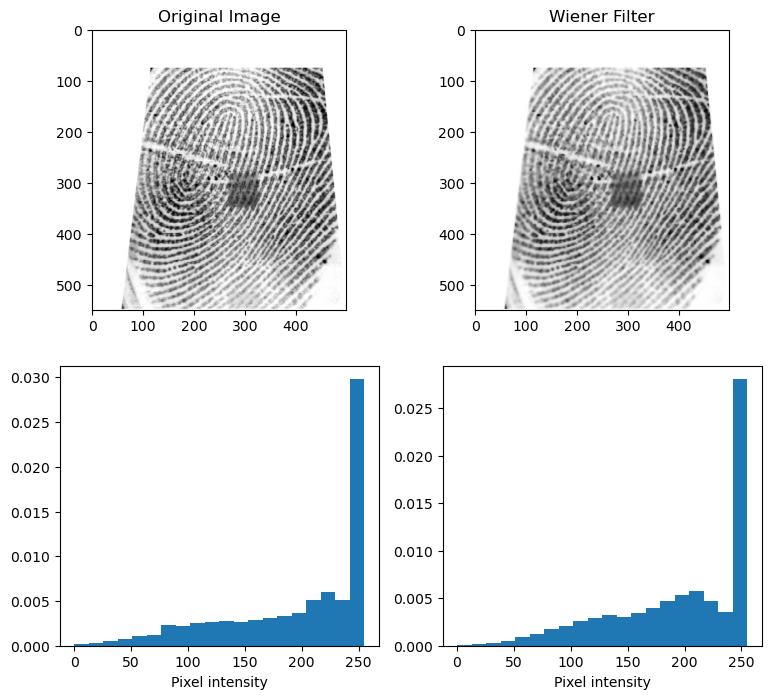

In [19]:
plt.figure(figsize=(14,8))
plt.subplot(2,3,1)
plt.imshow(image1GoodLeft, cmap='gray')
plt.title('Original Image')
plt.subplot(2,3,2)
plt.imshow(image1WienerGoodLeft, cmap='gray')
plt.title('Wiener Filter')
plt.subplot(2,3,4)
plt.hist(image1GoodLeft.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(image1WienerGoodLeft.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')

##### Plotting the Bad Left Thumb Fingerprint with De-noising Filtering(Wiener Filter) and Images

Text(0.5, 0, 'Pixel intensity')

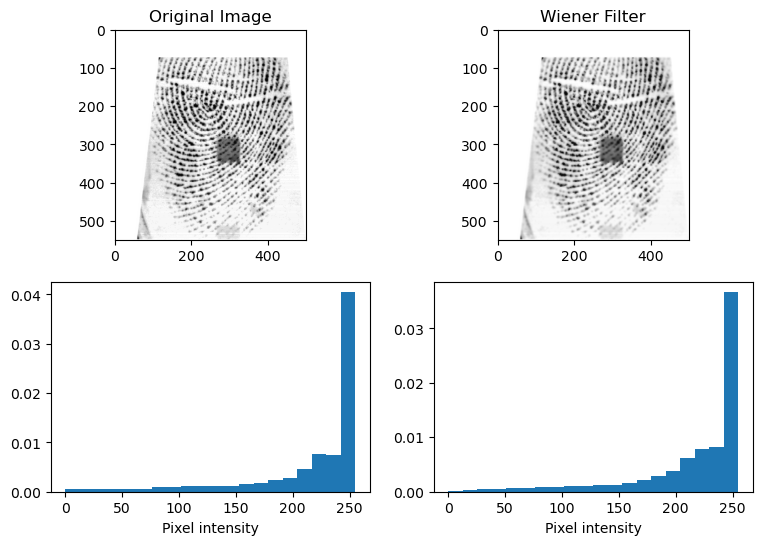

In [16]:
plt.figure(figsize=(14,6))
plt.subplot(2,3,1)
plt.imshow(image2BadLeft, cmap='gray')
plt.title('Original Image')
plt.subplot(2,3,2)
plt.imshow(image2WienerBadLeft, cmap='gray')
plt.title('Wiener Filter')
plt.subplot(2,3,4)
plt.hist(image2BadLeft.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(image2WienerBadLeft.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')

##### Loading and processing with De-noising-Exercise 2 Good/Bad Right Thumb Fingerprint

In [25]:
# Exercise 2 
# Load Images from the data collected during the lab 
image1GoodRight = img_as_ubyte(imread('./Abhay Fingerprints/Right Thumb/10.bmp', as_gray=True)) # Converting the image to grayscale
image2BadRight = img_as_ubyte(imread('./Abhay Fingerprints/Right Thumb/3.bmp', as_gray=True)) # Converting the image to grayscale

# Parameters for processing
seg_threshold = 0.4
block_size = 16

# Image processing without the De-noising filtering
print('Processing good right thumb fingerprint without De-noising filtering')
Fp1ProcessingGoodRight= fingerprint_processing(image1GoodRight, block_size=block_size, threshold=seg_threshold)
print('Processing bad right thumb fingerprint without De-noising filtering')
Fp2ProcessingBadRight = fingerprint_processing(image2BadRight, block_size=block_size, threshold=seg_threshold)

# De-noising filtering using the Wiener filter
image1WienerGoodRight = wiener(image1GoodRight.astype('float'), (5,5)) # Wiener filter requires the image to be as a float  
image1WienerGoodRight = img_as_ubyte((image1WienerGoodRight-np.min(image1WienerGoodRight))/(np.max(image1WienerGoodRight)-np.min(image1WienerGoodRight))) # Convert back to uint8 the output

image2WienerBadRight = wiener(image2BadRight.astype('float'), (5,5)) # Wiener filter requires the image to be as a float  
image2WienerBadRight = img_as_ubyte((image2WienerBadRight-np.min(image2WienerBadRight))/(np.max(image2WienerBadRight)-np.min(image2WienerBadRight))) # Convert back to uint8 the output

# Image processing after De-noising filtering 
print('Processing good right thumb fingerprint with De-noising filtering')
Fp3ProcessingGoodRightDenoising = fingerprint_processing(image1WienerGoodRight, block_size=block_size, threshold=seg_threshold)

print('Processing bad right thumb fingerprint with De-noising filtering')
Fp4ProcessingBadRightDenoising = fingerprint_processing(image2WienerBadRight, block_size=block_size, threshold=seg_threshold)

Processing good right thumb fingerprint without De-noising filtering
Total of minutiae detected: 82
Total of singularities detected: 4
Processing bad right thumb fingerprint without De-noising filtering
Total of minutiae detected: 45
Total of singularities detected: 0
Processing good right thumb fingerprint with De-noising filtering
Total of minutiae detected: 59
Total of singularities detected: 3
Processing bad right thumb fingerprint with De-noising filtering
Total of minutiae detected: 30
Total of singularities detected: 0


##### Plotting the Good Right Thumb Fingerprint with De-noising Filtering(Wiener Filter) and Images

Text(0.5, 0, 'Pixel intensity')

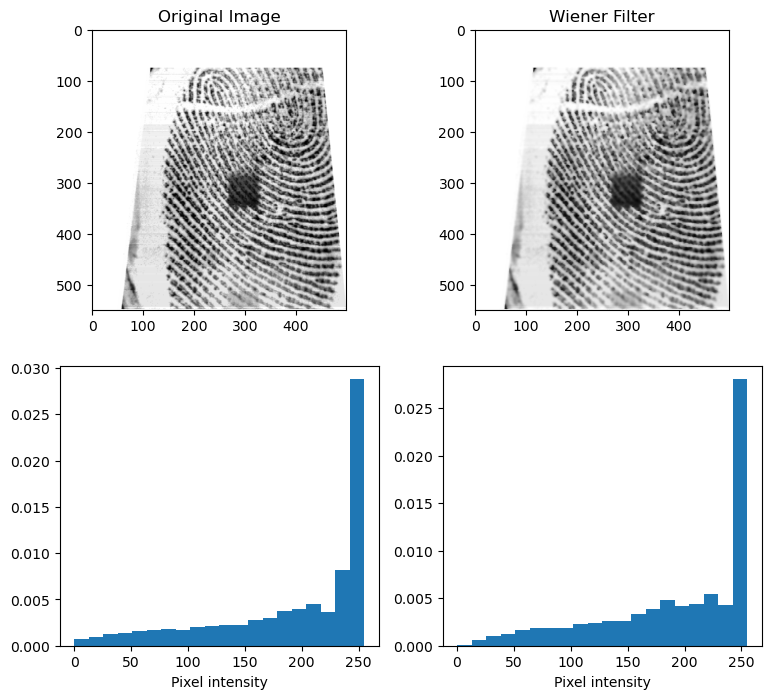

In [22]:
plt.figure(figsize=(14,8))
plt.subplot(2,3,1)
plt.imshow(image1GoodRight, cmap='gray')
plt.title('Original Image')
plt.subplot(2,3,2)
plt.imshow(image1WienerGoodRight, cmap='gray')
plt.title('Wiener Filter')
plt.subplot(2,3,4)
plt.hist(image1GoodRight.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(image1WienerGoodRight.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')

##### Plotting the Bad Right Thumb Fingerprint with De-noising Filtering(Wiener Filter) and Images

Text(0.5, 0, 'Pixel intensity')

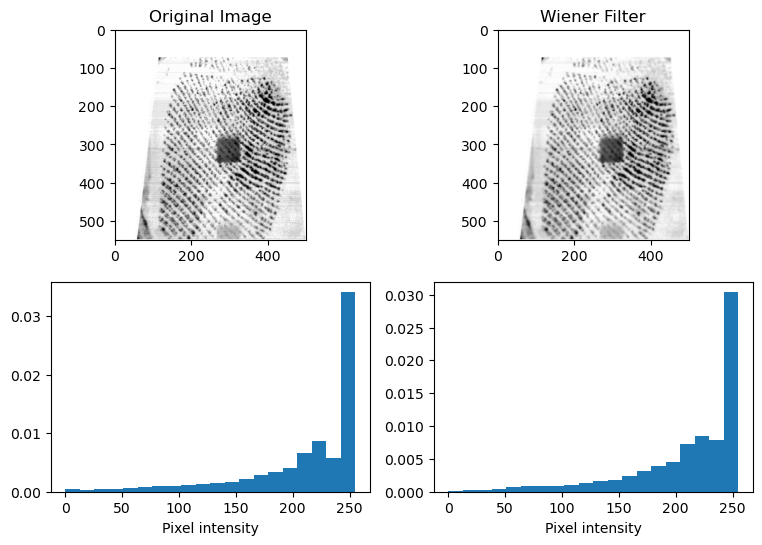

In [23]:
plt.figure(figsize=(14,6))
plt.subplot(2,3,1)
plt.imshow(image2BadRight, cmap='gray')
plt.title('Original Image')
plt.subplot(2,3,2)
plt.imshow(image2WienerBadRight, cmap='gray')
plt.title('Wiener Filter')
plt.subplot(2,3,4)
plt.hist(image2BadRight.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(image2WienerBadRight.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')

##### Number of minutiae and singularities detected WITHOUT the De-noising filtering step-Left Thumb Fingerprint
| Condition |      Minutiae     |  Singularities |
|----------|:-------------:|------:|
| Good  |  73 | 8 |
| Bad |    48  |   4 |

##### Number of minutiae and singularities detected WITH the De-noising filtering step-Left Thumb Fingerprint
| Condition |      Minutiae     |  Singularities |
|----------|:-------------:|------:|
| Good  |  55 | 4 |
| Bad |    47  |   4 |

##### Number of minutiae and singularities detected WITHOUT the De-noising filtering step-Right Thumb Fingerprint
| Condition |      Minutiae     |  Singularities |
|----------|:-------------:|------:|
| Good  |  82 | 4 |
| Bad |    45  |   0 |

##### Number of minutiae and singularities detected WITH the De-noising filtering step-Right Thumb Fingerprint
| Condition |      Minutiae     |  Singularities |
|----------|:-------------:|------:|
| Good  |  59 | 3 |
| Bad |    30  |   0 |

#### Comparison of the quantity of minutiae and singularities detected WITHOUT and WITH the Denoising Filter step
The data that is presented above in the has some variance in the number of minutiae and singularities detected in fingerprints with and without the denoising filtering step using the Wiener filtering. A higher number of minutiae generally correlates with more detailed information, enhancing the accuracy of fingerprint identification. The data reveals that the de-noising filtering process affects the detection of minutiae and singularities in varying ways, depending on the initial quality of the fingerprint. For good quality prints, de-noising appears to reduce the number of detected minutiae, suggesting that some valid minutiae may be incorrectly filtered out along with noise. For bad quality prints, the de-noising process does not significantly alter the number of detected minutiae, indicating its potential effectiveness in maintaining crucial details in noisy data. This implies that while a higher count of minutiae is generally preferred for accurate identification, the de-noising step must be carefully calibrated to enhance identification accuracy without compromising the integrity of the fingerprint data. The Wiener Filter algorithm minimizes the square error between the original and reconstructed images. Wiener filtering is a low-pass filter, but instead of having a single cutoff frequency, it is a space-varying filter. The images are degraded by additive noise and blurring.

<b>Note: Our findings could result in a different set because the choosing of the fingerprints is based on our judgment and we might consider different aspects. Henceforth these are not generalized instead based on our data which is uploaded with the lab submission.</b>

**Exercise 3** (4 marks): In this exercise, perform the same steps as in Exercise 1, but consider the **parameters `block_size` and `threshold`**. Evaluate the impact of these parameters by changing each of them to another value one at a time, for example: **change the `block_size` to 10 (`block_size = 10`) and keep the `threshold = 0.4`** (default). Second, **change the threshold only to `threshold = 0.5` while keeping the `block_size = 16`** (default). Evaluate  the number  of the detected minutiae and singularities. Compare the results and draw the conclusions.  

##### Loading and processing with De-noising-Exercise 2 Good/Bad Left Thumb Fingerprint

##### Parameter 1: Segmentation Threshold: 0.4, Block Size: 10 - Left Thumb Fingerprint

In [6]:
# Exercise 3  
# Load Images from the data collected during the lab 
image1GoodLeft = img_as_ubyte(imread('./Abhay Fingerprints/Left Thumb/10.bmp', as_gray=True)) # Converting the image to grayscale
image2BadLeft = img_as_ubyte(imread('./Abhay Fingerprints/Left Thumb/1.bmp', as_gray=True)) # Converting the image to grayscale

# Parameters for processing
seg_threshold = 0.4
block_size = 10

# Image processing
print('Processing good left thumb fingerprint without equalization')
Fp1ProcessingGoodLeft = fingerprint_processing(image1GoodLeft, block_size=block_size, threshold=seg_threshold)
print('Processing bad left thumb fingerprint without equalization')
Fp2ProcessingBadLeft = fingerprint_processing(image2BadLeft, block_size=block_size, threshold=seg_threshold)

# Equalization for contrast enhancement 
image1EqHistGoodLeft = img_as_ubyte(equalize_hist(image1GoodLeft))
image1EqAdaptGoodLeft = img_as_ubyte(equalize_adapthist(image1GoodLeft))

image2EqHistBadLeft = img_as_ubyte(equalize_hist(image2BadLeft))
image2EqAdaptBadLeft = img_as_ubyte(equalize_adapthist(image2BadLeft))

# Image processing after equalization
print('Processing good left thumb fingerprint with equalization adaption')
Fp3ProcessingGoodLeftEqualization = fingerprint_processing(image1EqAdaptGoodLeft, block_size=block_size, threshold=seg_threshold)

print('Processing bad left thumb fingerprint with equalization adaption')
Fp4ProcessingBadLeftEqualization = fingerprint_processing(image2EqAdaptBadLeft, block_size=block_size, threshold=seg_threshold)

Processing good left thumb fingerprint without equalization
Total of minutiae detected: 807
Total of singularities detected: 12
Processing bad left thumb fingerprint without equalization
Total of minutiae detected: 428
Total of singularities detected: 18
Processing good left thumb fingerprint with equalization adaption
Total of minutiae detected: 981
Total of singularities detected: 12
Processing bad left thumb fingerprint with equalization adaption
Total of minutiae detected: 433
Total of singularities detected: 26


##### Parameter 2: Segmentation Threshold: 0.5, Block Size: 16 - Left Thumb Fingerprint

In [7]:
# Exercise 3  
# Load Images from the data collected during the lab 
image1GoodLeft = img_as_ubyte(imread('./Abhay Fingerprints/Left Thumb/10.bmp', as_gray=True)) # Converting the image to grayscale
image2BadLeft = img_as_ubyte(imread('./Abhay Fingerprints/Left Thumb/1.bmp', as_gray=True)) # Converting the image to grayscale

# Parameters for processing
seg_threshold = 0.5
block_size = 16

# Image processing
print('Processing good left thumb fingerprint without equalization')
Fp1ProcessingGoodLeft = fingerprint_processing(image1GoodLeft, block_size=block_size, threshold=seg_threshold)
print('Processing bad left thumb fingerprint without equalization')
Fp2ProcessingBadLeft = fingerprint_processing(image2BadLeft, block_size=block_size, threshold=seg_threshold)

# Equalization for contrast enhancement 
image1EqHistGoodLeft = img_as_ubyte(equalize_hist(image1GoodLeft))
image1EqAdaptGoodLeft = img_as_ubyte(equalize_adapthist(image1GoodLeft))

image2EqHistBadLeft = img_as_ubyte(equalize_hist(image2BadLeft))
image2EqAdaptBadLeft = img_as_ubyte(equalize_adapthist(image2BadLeft))

# Image processing after equalization
print('Processing good left thumb fingerprint with equalization adaption')
Fp3ProcessingGoodLeftEqualization = fingerprint_processing(image1EqAdaptGoodLeft, block_size=block_size, threshold=seg_threshold)

print('Processing bad left thumb fingerprint with equalization adaption')
Fp4ProcessingBadLeftEqualization = fingerprint_processing(image2EqAdaptBadLeft, block_size=block_size, threshold=seg_threshold)

Processing good left thumb fingerprint without equalization
Total of minutiae detected: 65
Total of singularities detected: 4
Processing bad left thumb fingerprint without equalization
Total of minutiae detected: 47
Total of singularities detected: 4
Processing good left thumb fingerprint with equalization adaption
Total of minutiae detected: 72
Total of singularities detected: 8
Processing bad left thumb fingerprint with equalization adaption
Total of minutiae detected: 41
Total of singularities detected: 4


##### Parameter 3: Segmentation Threshold: 0.3, Block Size: 16 - Right Thumb Fingerprint

In [8]:
# Exercise 3 
# Load Images from the data collected during the lab 
image1GoodRight = img_as_ubyte(imread('./Abhay Fingerprints/Right Thumb/10.bmp', as_gray=True)) # Converting the image to grayscale
image2BadRight = img_as_ubyte(imread('./Abhay Fingerprints/Right Thumb/3.bmp', as_gray=True)) # Converting the image to grayscale

# Parameters for processing
seg_threshold = 0.3
block_size = 16

# Image processing
print('Processing good right thumb fingerprint without equalization')
Fp1ProcessingGoodRight = fingerprint_processing(image1GoodRight, block_size=block_size, threshold=seg_threshold)
print('Processing bad right thumb fingerprint without equalization')
Fp2ProcessingBadRight = fingerprint_processing(image2BadRight, block_size=block_size, threshold=seg_threshold)

# Equalization for contrast enhancement 
image1EqHistGoodRight = img_as_ubyte(equalize_hist(image1GoodRight))
image1EqAdaptGoodRight = img_as_ubyte(equalize_adapthist(image1GoodRight))

image2EqHistBadRight = img_as_ubyte(equalize_hist(image2BadRight))
image2EqAdaptBadRight = img_as_ubyte(equalize_adapthist(image2BadRight))

# Image processing after equalization
print('Processing good right thumb fingerprint with equalization adaption')
Fp3ProcessingGoodRightEqualization = fingerprint_processing(image1EqAdaptGoodRight, block_size=block_size, threshold=seg_threshold)

print('Processing bad right thumb fingerprint with equalization adaption')
Fp4ProcessingBadRightEqualization = fingerprint_processing(image2EqAdaptBadRight, block_size=block_size, threshold=seg_threshold)

Processing good right thumb fingerprint without equalization
Total of minutiae detected: 88
Total of singularities detected: 4
Processing bad right thumb fingerprint without equalization
Total of minutiae detected: 92
Total of singularities detected: 0
Processing good right thumb fingerprint with equalization adaption
Total of minutiae detected: 87
Total of singularities detected: 4
Processing bad right thumb fingerprint with equalization adaption
Total of minutiae detected: 195
Total of singularities detected: 0


##### Parameter 4: Segmentation Threshold: 0.6, Block Size: 16 - Right Thumb Fingerprint

In [9]:
# Exercise 3 
# Load Images from the data collected during the lab 
image1GoodRight = img_as_ubyte(imread('./Abhay Fingerprints/Right Thumb/10.bmp', as_gray=True)) # Converting the image to grayscale
image2BadRight = img_as_ubyte(imread('./Abhay Fingerprints/Right Thumb/3.bmp', as_gray=True)) # Converting the image to grayscale

# Parameters for processing
seg_threshold = 0.6
block_size = 16

# Image processing
print('Processing good right thumb fingerprint without equalization')
Fp1ProcessingGoodRight = fingerprint_processing(image1GoodRight, block_size=block_size, threshold=seg_threshold)
print('Processing bad right thumb fingerprint without equalization')
Fp2ProcessingBadRight = fingerprint_processing(image2BadRight, block_size=block_size, threshold=seg_threshold)

# Equalization for contrast enhancement 
image1EqHistGoodRight = img_as_ubyte(equalize_hist(image1GoodRight))
image1EqAdaptGoodRight = img_as_ubyte(equalize_adapthist(image1GoodRight))

image2EqHistBadRight = img_as_ubyte(equalize_hist(image2BadRight))
image2EqAdaptBadRight = img_as_ubyte(equalize_adapthist(image2BadRight))

# Image processing after equalization
print('Processing good right thumb fingerprint with equalization adaption')
Fp3ProcessingGoodRightEqualization = fingerprint_processing(image1EqAdaptGoodRight, block_size=block_size, threshold=seg_threshold)

print('Processing bad right thumb fingerprint with equalization adaption')
Fp4ProcessingBadRightEqualization = fingerprint_processing(image2EqAdaptBadRight, block_size=block_size, threshold=seg_threshold)

Processing good right thumb fingerprint without equalization
Total of minutiae detected: 42
Total of singularities detected: 0
Processing bad right thumb fingerprint without equalization
Total of minutiae detected: 34
Total of singularities detected: 0
Processing good right thumb fingerprint with equalization adaption
Total of minutiae detected: 79
Total of singularities detected: 4
Processing bad right thumb fingerprint with equalization adaption
Total of minutiae detected: 50
Total of singularities detected: 0


##### Parameters Tested Without Histogram Equalization-Exercise 3 and Good Condition
| Parameter Number  | Segmentation Threshold  |  Block Size | Minutiae | Singularities | Thumb Fingerprint |
|-------------------|:-----------------------:|------------:| --------:| -------------:| -----------------:| 
|        1          |             0.4         |      10      |  807    |      12       |       Left        |
|        2          |             0.5         |      16      |   65    |      4        |       Left        |
|        3          |             0.3         |      16      |   88    |      4        |       Right       |
|        4          |             0.6         |      16      |   42    |      0        |       Right       |

##### Parameters Tested Without Histogram Equalization-Exercise 3 and Bad Condition
| Parameter Number  | Segmentation Threshold  |  Block Size | Minutiae | Singularities | Thumb Fingerprint |
|-------------------|:-----------------------:|------------:| --------:| -------------:| -----------------:| 
|        1          |             0.4         |      10      |  428    |      18       |       Left        |
|        2          |             0.5         |      16      |   47    |      4        |       Left        |
|        3          |             0.3         |      16      |   92    |      0        |       Right       |
|        4          |             0.6         |      16      |   34    |      0        |       Right       |

##### Parameters Tested With Histogram Equalization-Exercise 3 and Good Condition
| Parameter Number  | Segmentation Threshold  |  Block Size | Minutiae | Singularities | Thumb Fingerprint |
|-------------------|:-----------------------:|------------:| --------:| -------------:| -----------------:| 
|        1          |             0.4         |      10      |  981    |      12       |       Left        |
|        2          |             0.5         |      16      |   72    |      8        |       Left        |
|        3          |             0.3         |      16      |   87    |      4        |       Right       |
|        4          |             0.6         |      16      |   79    |      4        |       Right       |

##### Parameters Tested With Histogram Equalization-Exercise 3 and Bad Condition
| Parameter Number  | Segmentation Threshold  |  Block Size | Minutiae | Singularities | Thumb Fingerprint |
|-------------------|:-----------------------:|------------:| --------:| -------------:| -----------------:| 
|        1          |             0.4         |      10      |  433    |      26       |       Left        |
|        2          |             0.5         |      16      |   41    |      4        |       Left        |
|        3          |             0.3         |      16      |   195   |      0        |       Right       |
|        4          |             0.6         |      16      |   50    |      0        |       Right       |

##### Analysis of the impact of the parameters `block_size` and `seg_threshold`

As seen, changing the segmentation threshold significantly affects the minutiae. As its increased from 0.3 to 0.6 for the same thumb, we can see that there is a decrease in minutiae detected but no change in singularities. 

When decreasing the block_size to 10 and keeping the segmentation threshold at 0.4, we see it increase almost 13x in minutiae. Additionally, we see an increase in singularities as well (compared to values from ex1). Alluding to the fact that a decrease in blocksize most certainly increases minutiae and singularities by a large margin, larger than just increasing segmentation threshold. 

A decrease in segmentation threshold leads to a reduction in detected minutiae without affecting singularities, indicating a higher level of segmentation, potentially resulting in merging of minutiae points. Conversely, decreasing the block size significantly increases the number of detected minutiae and singularities, suggesting finer detail extraction from the fingerprint image. These variations underscore the sensitivity of fingerprint analysis to segmentation parameters and highlight the trade-offs between minutiae and singularities detection, influencing the accuracy and reliability of fingerprint recognition systems.

<b>Note: Our findings could result in a different set because the choosing of the fingerprints is based on our judgment and we might consider different aspects. Henceforth these are not generalized instead based on our data which is uploaded with the lab submission.</b>

## Conclusion

In conclusion, our exploration of fingerprint analysis has revealed the intricate relationship between segmentation parameters and the detection of minutiae and singularities. Notably, adjustments in segmentation threshold and block size have demonstrated significant impacts on the quantity of detected minutiae and singularities, shedding light on the sensitivity of the analysis process. Moreover, incorporating histogram equalization and denoising filtering, such as the Wiener filter, has proven instrumental in enhancing the quality of fingerprint images. Histogram equalization aids in improving contrast and enhancing the visibility of ridge structures, thereby facilitating more accurate feature extraction. Meanwhile, the Wiener filter effectively reduces noise and artifacts, resulting in cleaner and more precise fingerprint images for analysis. These additional techniques contribute to the overall robustness and reliability of fingerprint recognition systems, underscoring the importance of employing a comprehensive approach to image processing in biometric security applications.